In [104]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR

from torchvision import models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [105]:
PATH = "/Volumes/Project/Competition/IIT Madras/Resnet/resnet.pt"

In [106]:
device

device(type='cpu')

In [107]:
import io
def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)

In [108]:
crack = ["Negative","Positive"]

# device = torch.device('mps')

In [109]:
class CrackPredictorModel(nn.Module):
    def __init__(self, n_classes=2):
        super(CrackPredictorModel, self).__init__()
        # Get pretrained ResNet50 backbone
        self.backbone = models.resnet50(weights='DEFAULT')
        
        # Freeze backbone layers
        for parameter in self.backbone.parameters():
            parameter.requires_grad = False   
        
        # Add new head
        self.backbone.fc = nn.Sequential(nn.Linear(2048, 128),
                                         nn.ReLU(),
                                         nn.Linear(128, n_classes),
                                        )

    def forward(self, x):
        return self.backbone(x)

Negative  at confidence score:1.00


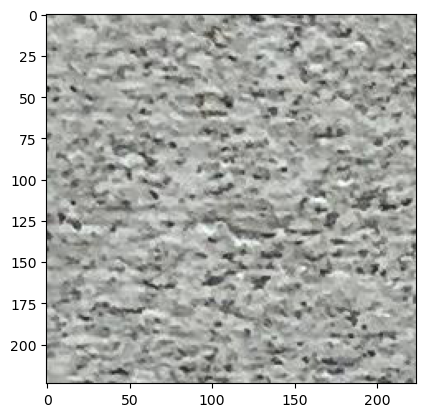

In [113]:

model = torch.load(PATH)
model.eval()

def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    tensor=tensor.to(torch.device('mps'))
    output = model.forward(tensor)
    
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)
    return conf.item(), crack[classes.item()]

image_path="/Volumes/Project/Competition/IIT Madras/dataset/valid/Negative/IMG_3077_5_5.jpg"
image = plt.imread(image_path)
plt.imshow(image)

with open(image_path, 'rb') as f:
    image_bytes = f.read()

    conf,y_pre=get_prediction(image_bytes=image_bytes)
    print(y_pre, ' at confidence score:{0:.2f}'.format(conf))

In [114]:
idx_to_class= ["Negative","Positive"]

In [115]:
# Input image dimensions
H = 224
W = 224

In [116]:
def get_transforms(train):
    # Since we are using pretrained ResNet-50, normalize images with ImageNet statistics
    normalization = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    if (train):
        return transforms.Compose([transforms.RandomCrop((H, W)),
                                   transforms.RandomVerticalFlip(),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   normalization,
                                   ])
    else:
        return transforms.Compose([transforms.Resize((H, W)),
                                   transforms.ToTensor(),
                                   normalization,
                                  ])

In [162]:
def predict(model, test_image, print_class = False):
     # it uses the model to predict on test_image...
    # transform = get_transforms['val']
    transform = get_transforms(0)
     
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available(): # checks if we have a gpu available
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
        test_image_tensor.to(torch.device('mps'))
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        # this computes the output of the model
        out = model(test_image_tensor.to(torch.device('mps')))
        # this computes the probability of each classes.
        ps = torch.exp(out)
        # we choose the top class. That is, the class with highest probability
        topk, topclass = ps.topk(1, dim=1)
        class_name = idx_to_class[topclass.cpu().numpy()[0][0]]
        if print_class:
            print("Output class :  ", class_name)
    return class_name

In [181]:
import cv2
import os


def predict_on_crops(input_image, height=224, width=224, save_crops = False):
    count = 0
    im = cv2.imread(input_image)
    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            ## discard image cropss that are not full size
            # print(Image.fromarray(a))
            predicted_class = predict(model,Image.fromarray(a))
            ## save image
            # file, ext = os.path.splitext(input_image)
            # image_name = file.split('/')[-1]
            # folder_name = 'out_' + image_name
            ## Put predicted class on the image
            if predicted_class == 'Positive':
                count += 1
    return count
            

In [182]:
# plt.figure(figsize=(10,10))
output_image = predict_on_crops("/Volumes/Project/Competition/IIT Madras/dataset/predict/IMG_1134.JPG")
# plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
if output_image > 3:
    print("Cracked")

Cracked
